In [1838]:
# 라이브러리, 데이터
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import shap
from sklearn.calibration import LabelEncoder
import numpy as np
from sklearn.model_selection import learning_curve

sns_df = pd.read_csv("./data/Social_Network_Ads.csv")

shap.initjs()

### 데이터 개요

In [1839]:
sns_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [1840]:
# user id 열 버리기
sns_df.drop('User ID', axis=1, inplace=True)
sns_df

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0
...,...,...,...,...
395,Female,46,41000,1
396,Male,51,23000,1
397,Female,50,20000,1
398,Male,36,33000,0


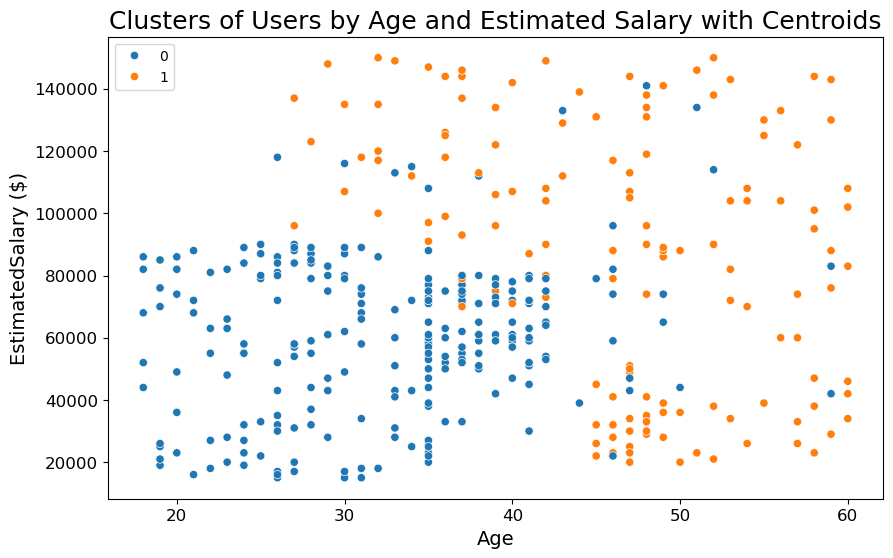

In [1841]:
# 클러스터링 시각화
plt.figure(figsize=(10, 6))

# 산점도 그리기
sns.scatterplot(x='Age', y='EstimatedSalary', hue = 'Purchased', data=sns_df)

plt.title('Clusters of Users by Age and Estimated Salary with Centroids',fontsize=18)
plt.xlabel('Age',fontsize=14)
plt.ylabel('EstimatedSalary ($)', fontsize=14)
plt.xticks(fontsize=12)  # x축 눈금 글자 크기
plt.yticks(fontsize=12)  # y축 눈금 글자 크기
plt.legend()
plt.show()

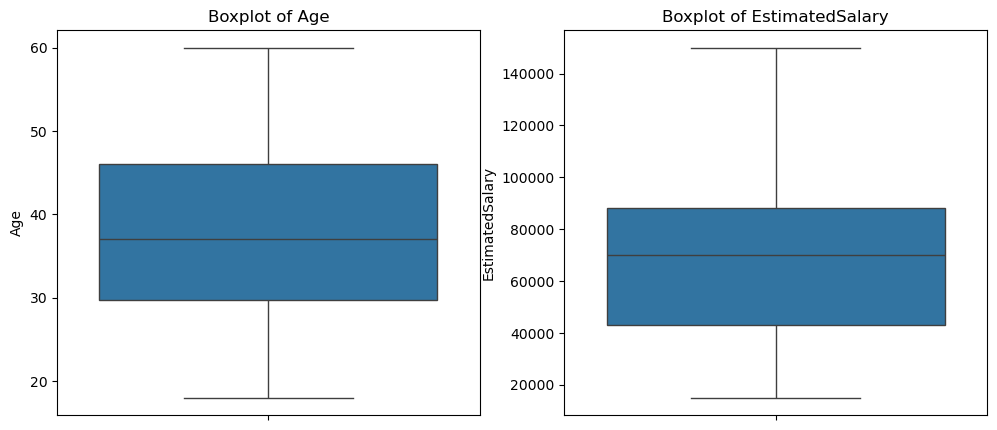

(0, 0)

In [1842]:
# 나이와 소득의 이상치 찾기
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(sns_df['Age'])
plt.title('Boxplot of Age')

plt.subplot(1, 2, 2)
sns.boxplot(sns_df['EstimatedSalary'])
plt.title('Boxplot of EstimatedSalary')

plt.show()

# Identify outliers in 'Age' and 'EstimatedSalary'
Q1_age = sns_df['Age'].quantile(0.25)
Q3_age = sns_df['Age'].quantile(0.75)
IQR_age = Q3_age - Q1_age
age_outliers = sns_df[(sns_df['Age'] < Q1_age - 1.5 * IQR_age) | (sns_df['Age'] > Q3_age + 1.5 * IQR_age)]

Q1_salary = sns_df['EstimatedSalary'].quantile(0.25)
Q3_salary = sns_df['EstimatedSalary'].quantile(0.75)
IQR_salary = Q3_salary - Q1_salary
salary_outliers = sns_df[(sns_df['EstimatedSalary'] < Q1_salary - 1.5 * IQR_salary) | (sns_df['EstimatedSalary'] > Q3_salary + 1.5 * IQR_salary)]

len(age_outliers), len(salary_outliers)

### 나이와 소득 수준으로 클러스터링

In [1843]:
# feature 선택
features = sns_df[['Age', 'EstimatedSalary']]

# 표준화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [1844]:
# 이상적인 클러스터 수 찾기
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=12345)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_) # 최적의 클러스터 수 계산

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are les

In [1845]:
wcss

[800.0000000000001,
 504.6901975495464,
 323.8459702124485,
 246.4369319981107,
 181.46262504427386,
 133.7627522440052,
 113.14281030766202,
 99.83860113835634,
 89.1010299379931,
 80.31748921785923]

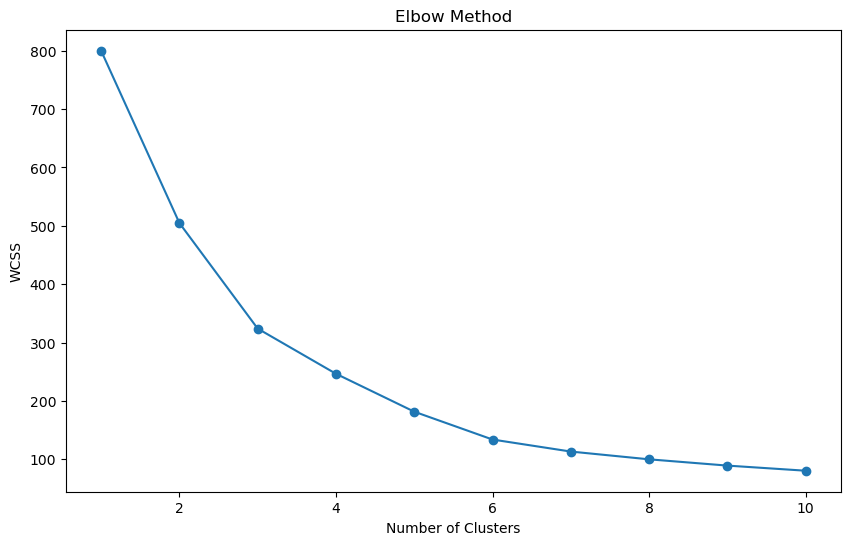

In [1846]:
# elbow curve
# 그래프가 에서 기울기의 변화가 가장 큰 점이 적정 클러스터이다.
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [1847]:
# 실루엣 스코어 보기
silhouette_scores = {}
for k in range(2, 11):  # KMeans는 최소 2개의 클러스터가 필요하므로 k=2부터 시작
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=12345)
    clusters = kmeans.fit_predict(scaled_features)
    sil_score = silhouette_score(scaled_features, clusters)
    silhouette_scores[k] = sil_score

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are les

In [1848]:
for k, score in silhouette_scores.items():
    print(f'k={k}: Silhouette Score = {score:.4f}')

k=2: Silhouette Score = 0.3830
k=3: Silhouette Score = 0.3624
k=4: Silhouette Score = 0.3747
k=5: Silhouette Score = 0.4158
k=6: Silhouette Score = 0.4486
k=7: Silhouette Score = 0.4512
k=8: Silhouette Score = 0.4060
k=9: Silhouette Score = 0.4137
k=10: Silhouette Score = 0.4009


In [1849]:
# 실루엣 스코어를 보니 7이 알맞아 보임.
optimal_clusters = 7
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=12345)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the original data
sns_df['Cluster'] = clusters

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [1850]:
# Show cluster centers
centers = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers)
centers

array([[3.49024390e+01, 1.22219512e+05],
       [3.82522523e+01, 6.55135135e+04],
       [2.55555556e+01, 7.47222222e+04],
       [5.01346154e+01, 3.36346154e+04],
       [5.02222222e+01, 1.33740741e+05],
       [5.22222222e+01, 8.67777778e+04],
       [2.79016393e+01, 2.86885246e+04]])

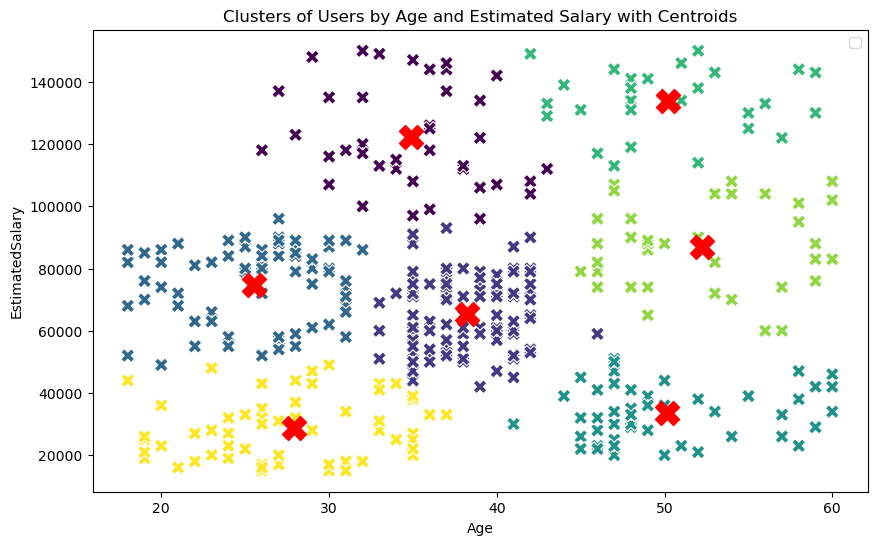

In [1851]:
# 클러스터링 시각화
plt.figure(figsize=(10, 6))

# 산점도 그리기
sns.scatterplot(x='Age', y='EstimatedSalary', hue=clusters, data=sns_df, palette='viridis', s=100, style=clusters , markers=['X']*optimal_clusters,)

# 클러스터 중심 따로 그리기
centers = kmeans.cluster_centers_  # 표준화 되어있는 상태이다.
centers = scaler.inverse_transform(centers)  # 표준화 해제

plt.scatter(centers[:, 0], centers[:, 1], c='red', s=300, marker='X', label='Centroids')
plt.title('Clusters of Users by Age and Estimated Salary with Centroids')
plt.xlabel('Age')
plt.ylabel('EstimatedSalary')
plt.legend("")
plt.show()

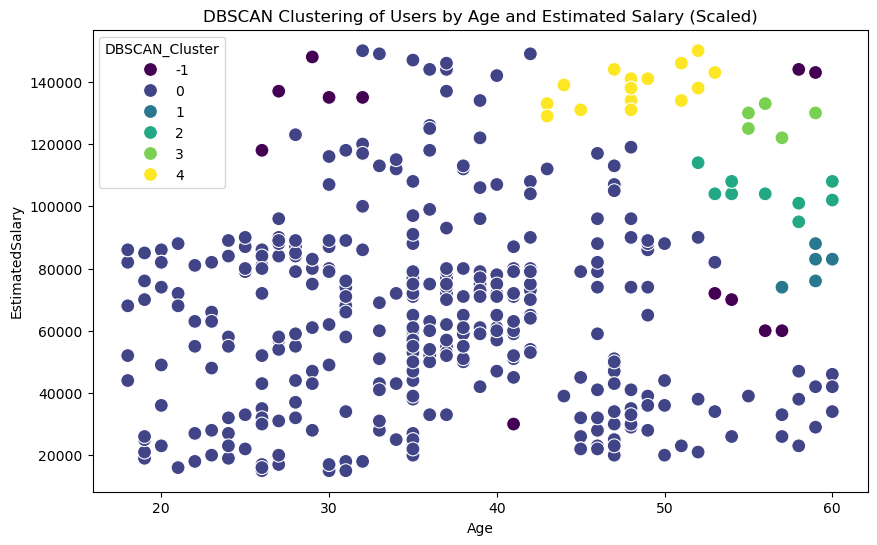

In [1852]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns


# Apply DBSCAN clustering algorithm
dbscan = DBSCAN(eps=0.35, min_samples=5)
clusters_dbscan = dbscan.fit_predict(scaled_features)

# Add DBSCAN cluster labels to the original data
sns_df['DBSCAN_Cluster'] = clusters_dbscan

# Visualize the clusters formed by DBSCAN
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='EstimatedSalary', hue='DBSCAN_Cluster', palette='viridis', data=sns_df, s=100, marker='o')
plt.title('DBSCAN Clustering of Users by Age and Estimated Salary (Scaled)')
plt.xlabel('Age')
plt.ylabel('EstimatedSalary')
plt.show()


### 결제 여부로 분류 모델도 만들어 보기.

In [1853]:


le = LabelEncoder()
sns_df['Gender'] = le.fit_transform(sns_df['Gender'])

In [1854]:
features = [
    'Age', 'EstimatedSalary'
]

X = sns_df[features]
y = sns_df['Purchased']


In [1855]:
X

,Age,EstimatedSalary
0,19,19000
1,35,20000
2,26,43000
3,27,57000
4,19,76000
...,...,...
395,46,41000
396,51,23000
397,50,20000
398,36,33000


In [1856]:
# Models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=12345),
    'Decision Tree': DecisionTreeClassifier(random_state=12345),
    'Random Forest': RandomForestClassifier(random_state=12345),
    'SVM': SVC(random_state=12345),
    'KNN': KNeighborsClassifier(),
    'AB' : AdaBoostClassifier(random_state=12345)
}

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=False)

# Dictionary to hold the accuracy scores
model_scores = {model_name: [] for model_name in models.keys()}

# Perform cross-validation for each model
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        model_scores[model_name].append(accuracy)

# Print the accuracy for each fold and the average accuracy for each model
for model_name, scores in model_scores.items():
    print(f"{model_name}:")
    for i, score in enumerate(scores, 1):
        print(f"  Fold {i} Accuracy: {score:.2%}")
    print(f"  Average Accuracy: {sum(scores) / len(scores):.2%}\n")



Logistic Regression:
  Fold 1 Accuracy: 65.00%
  Fold 2 Accuracy: 65.00%
  Fold 3 Accuracy: 63.75%
  Fold 4 Accuracy: 81.25%
  Fold 5 Accuracy: 62.50%
  Average Accuracy: 67.50%

Decision Tree:
  Fold 1 Accuracy: 75.00%
  Fold 2 Accuracy: 90.00%
  Fold 3 Accuracy: 82.50%
  Fold 4 Accuracy: 77.50%
  Fold 5 Accuracy: 77.50%
  Average Accuracy: 80.50%

Random Forest:
  Fold 1 Accuracy: 80.00%
  Fold 2 Accuracy: 93.75%
  Fold 3 Accuracy: 91.25%
  Fold 4 Accuracy: 81.25%
  Fold 5 Accuracy: 82.50%
  Average Accuracy: 85.75%

SVM:
  Fold 1 Accuracy: 81.25%
  Fold 2 Accuracy: 86.25%
  Fold 3 Accuracy: 73.75%
  Fold 4 Accuracy: 81.25%
  Fold 5 Accuracy: 63.75%
  Average Accuracy: 77.25%

KNN:
  Fold 1 Accuracy: 81.25%
  Fold 2 Accuracy: 86.25%
  Fold 3 Accuracy: 72.50%
  Fold 4 Accuracy: 76.25%
  Fold 5 Accuracy: 67.50%
  Average Accuracy: 76.75%

AB:
  Fold 1 Accuracy: 72.50%
  Fold 2 Accuracy: 93.75%
  Fold 3 Accuracy: 86.25%
  Fold 4 Accuracy: 81.25%
  Fold 5 Accuracy: 85.00%
  Average Accur

C:\Users\user\AppData\Local\Temp\ipykernel_13912\2886745507.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Average Accuracy', y='Model', data=scores_df, palette='viridis')


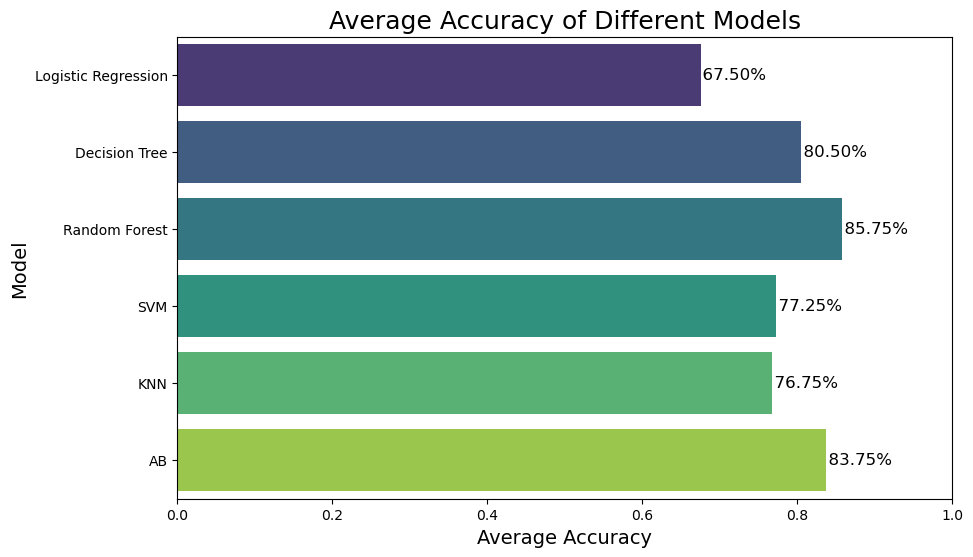

In [1857]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average accuracy for each model
average_scores = {model_name: sum(scores) / len(scores) for model_name, scores in model_scores.items()}

# Convert to a pandas DataFrame for easier plotting
scores_df = pd.DataFrame(list(average_scores.items()), columns=['Model', 'Average Accuracy'])



# Plotting the barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Average Accuracy', y='Model', data=scores_df, palette='viridis')

for index, value in enumerate(scores_df['Average Accuracy']):
    ax.text(value + 0.01, index, f'          {value * 100:.2f}%', color='black', ha="center", va="center", fontsize=12)

plt.title('Average Accuracy of Different Models', fontsize =18)
plt.xlabel('Average Accuracy', fontsize =14)
plt.ylabel('Model', fontsize =14)
plt.xlim(0, 1)  # Accuracy is between 0 and 1

plt.show()


In [1858]:
# randomforestclassifier가 가장 정확도가 높으므로 선택.

rfc = RandomForestClassifier(random_state=12345)
scaled_features = scaler.fit_transform(sns_df[features])

X = scaled_features

In [1859]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=12345)

In [1860]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'min_samples_leaf': [1, 2, 4]
}

# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

# GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, refit=True, return_train_score=True)
grid_search.fit(X_train, y_train)

# 최적의 파라미터와 최적의 스코어 출력
scores_df = pd.DataFrame(grid_search.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score',
           'split0_test_score', 'split1_test_score', 'split2_test_score']].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
9,"{'min_samples_leaf': 4, 'n_estimators': 200}",0.918750,1,0.921875,0.937500,0.921875
10,"{'min_samples_leaf': 4, 'n_estimators': 300}",0.918750,1,0.921875,0.937500,0.921875
11,"{'min_samples_leaf': 4, 'n_estimators': 400}",0.918750,1,0.921875,0.937500,0.921875
8,"{'min_samples_leaf': 4, 'n_estimators': 100}",0.909375,4,0.875000,0.937500,0.921875
7,"{'min_samples_leaf': 2, 'n_estimators': 400}",0.903125,5,0.859375,0.937500,0.921875
4,"{'min_samples_leaf': 2, 'n_estimators': 100}",0.900000,6,0.859375,0.921875,0.921875
5,"{'min_samples_leaf': 2, 'n_estimators': 200}",0.900000,6,0.859375,0.921875,0.921875
6,"{'min_samples_leaf': 2, 'n_estimators': 300}",0.900000,6,0.859375,0.921875,0.921875
0,"{'min_samples_leaf': 1, 'n_estimators': 100}",0.884375,9,0.828125,0.906250,0.890625
2,"{'min_samples_leaf': 1, 'n_estimators': 300}",0.884375,9,0.843750,0.906250,0.890625


In [1861]:
y_pred = grid_search.predict(X_test)

In [1862]:
grid_search.score(X_train, y_train)

0.940625

In [1863]:
accuracy_score(y_pred, y_test)

0.875

In [1864]:
cm = metrics.confusion_matrix(y_test, y_pred)

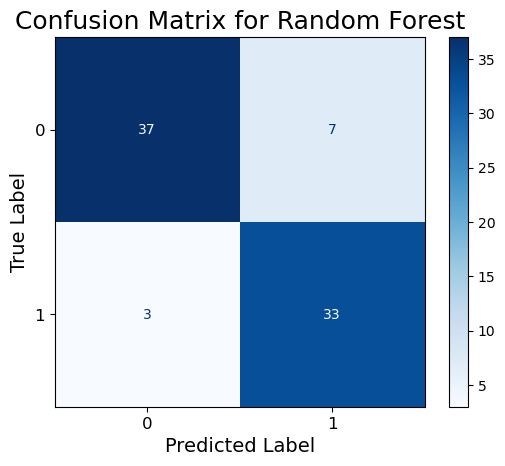

In [1865]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Random Forest', fontsize = 18)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)  # x축 눈금 글자 크기
plt.yticks(fontsize=12)  # y축 눈금 글자 크기
plt.show()

In [1866]:
y_scores = grid_search.predict_proba(X_test)[:, 1]

In [1867]:
from sklearn.metrics import roc_auc_score

# AUC 값 계산
auc_value = roc_auc_score(y_test, y_scores)

auc_value

0.928030303030303

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


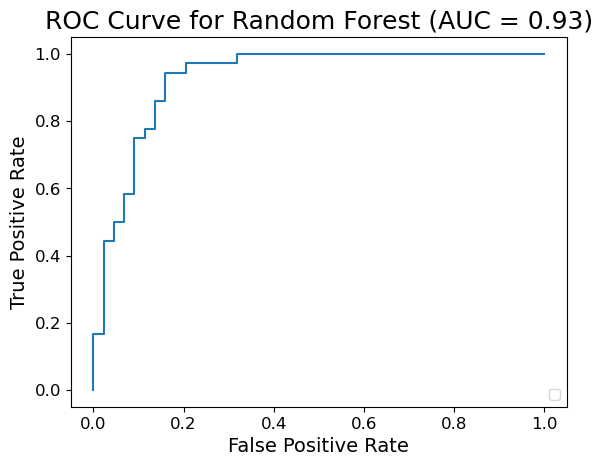

In [1879]:
from sklearn.metrics import roc_curve, RocCurveDisplay

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_scores)

# ROC 곡선 그리기
roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_disp.plot()
plt.title(f'ROC Curve for Random Forest (AUC = {auc_value:.2f})', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xticks(fontsize=12)  # x축 눈금 글자 크기
plt.yticks(fontsize=12)  # y축 눈금 글자 크기
plt.show()

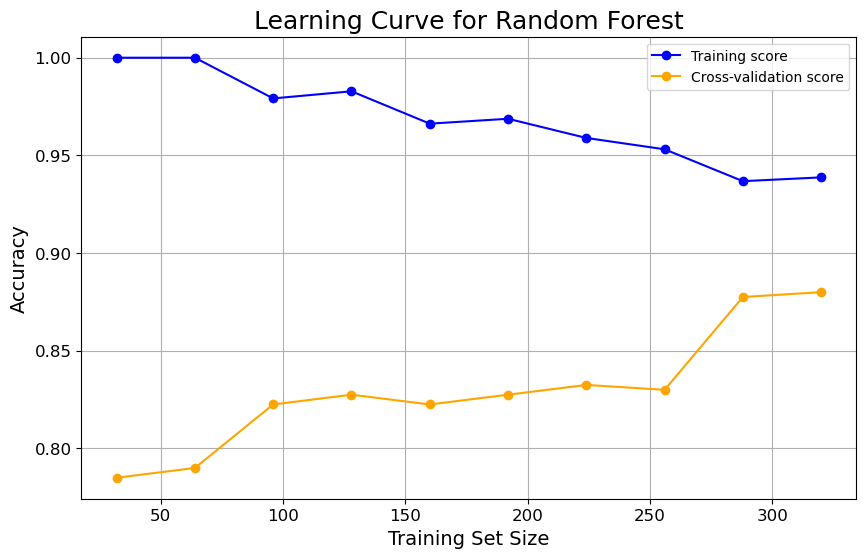

In [1869]:

# 학습 곡선 계산
train_sizes, train_scores, test_scores = learning_curve(
    grid_search, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=12345)

# 평균 및 표준편차 계산
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 학습 곡선 그리기
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Cross-validation score')

# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.1)

plt.title('Learning Curve for Random Forest', fontsize = 18)
plt.xlabel('Training Set Size', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.xticks(fontsize=12)  # x축 눈금 글자 크기
plt.yticks(fontsize=12)  # y축 눈금 글자 크기
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [1870]:
explainer = shap.KernelExplainer(grid_search.predict, X_test)
shap_values = explainer.shap_values(X_test)

  0%|          | 0/80 [00:00<?, ?it/s]

In [1871]:
shap_values

array([[-0.29375, -0.20625],
       [-0.325  , -0.175  ],
       [ 0.58125, -0.08125],
       [-0.2625 , -0.2375 ],
       [-0.25625, -0.24375],
       [ 0.6125 , -0.1125 ],
       [ 0.40625,  0.09375],
       [ 0.58125, -0.08125],
       [-0.2625 , -0.2375 ],
       [-0.29375, -0.20625],
       [-0.2625 , -0.2375 ],
       [-0.29375, -0.20625],
       [ 0.25   ,  0.25   ],
       [-0.375  , -0.125  ],
       [-0.11875,  0.61875],
       [-0.25625, -0.24375],
       [-0.25625, -0.24375],
       [-0.28125, -0.21875],
       [-0.14375,  0.64375],
       [ 0.58125, -0.08125],
       [-0.29375, -0.20625],
       [-0.3125 , -0.1875 ],
       [-0.29375, -0.20625],
       [-0.11875,  0.61875],
       [ 0.58125, -0.08125],
       [ 0.40625,  0.09375],
       [-0.25   , -0.25   ],
       [-0.28125, -0.21875],
       [ 0.025  ,  0.475  ],
       [-0.25   , -0.25   ],
       [-0.325  , -0.175  ],
       [ 0.58125, -0.08125],
       [ 0.6125 , -0.1125 ],
       [-0.29375, -0.20625],
       [-0.312

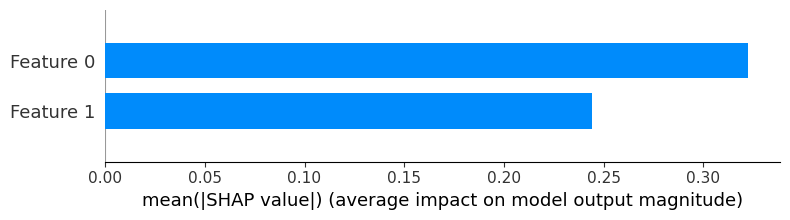

In [1875]:
# SHAP summary plot (전체 특징 중요도)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [1873]:
shap.force_plot(explainer.expected_value, shap_values, X_test)